In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import math
import os
import tempfile
import matplotlib as mpl
from sklearn.metrics import confusion_matrix



In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
#Karpathy 1. fix random seed
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

In [5]:
ATT_FILE_NAME = "FootballPlayerPreparedCleanAttributes.csv"
ONE_HOT_ENCODED_CLASSES_FILE_NAME = "FootballPlayerOneHotEncodedClasses.csv"

In [6]:
att = pd.read_csv(ATT_FILE_NAME)
target = pd.read_csv(ONE_HOT_ENCODED_CLASSES_FILE_NAME)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
att.describe()

,Crossing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Reactions,ShotPower,Stamina,LongShots,Aggression,Positioning,Vision,Composure
count,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000
mean,0.053537,0.064942,0.168294,-0.081373,0.122654,-0.030012,-0.132537,0.002751,0.076091,0.098800,0.125965,0.169170,-0.025506,0.136145,0.043417,0.060219,0.036497
std,0.344606,0.293820,0.268085,0.369549,0.301492,0.364944,0.358826,0.334822,0.282066,0.233806,0.326638,0.324097,0.379027,0.352347,0.349409,0.314939,0.274291
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.195122,-0.139241,0.013699,-0.375000,-0.012048,-0.325301,-0.428571,-0.189189,-0.070423,-0.066667,-0.086420,-0.014493,-0.301205,-0.097561,-0.166667,-0.146341,-0.162162
50%,0.097561,0.088608,0.205479,-0.075000,0.180723,-0.012048,-0.190476,0.054054,0.098592,0.093333,0.160494,0.188406,0.036145,0.170732,0.095238,0.097561,0.054054
75%,0.317073,0.265823,0.342466,0.200000,0.325301,0.253012,0.142857,0.243243,0.267606,0.253333,0.358025,0.391304,0.277108,0.390244,0.285714,0.292683,0.243243
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
target.head()

,"Poor:[46.0, 62.0]","Interm:[63.0, 66.0]","Good:[67.0, 71.0]","Excel:[72.0, 94.0]"
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0


In [14]:
clases = np.argmax(target.to_numpy(),axis=1)

In [16]:
np.bincount(clases) # contar cuantos elemntos tengo de cada clase en el conjunto de datos

array([4296, 3868, 4353, 3605], dtype=int64)

In [17]:
c1, c2,c3,c4= np.bincount(clases)
total = c1+c2+c3+c4
print(f"Total: {total}. C1 {c1}, c2 {c2}, c3 {c3}, c4 {c4}") #lo mismo de arriba

Total: 16122. C1 4296, c2 3868, c3 4353, c4 3605


In [18]:
X_train,X_rem,y_train,y_rem = train_test_split(att,target,train_size=0.8)
X_valid,X_test,y_valid,y_test = train_test_split(X_rem,y_rem,train_size=0.5)
#80 % train   --- 10% val 10% test

In [19]:
c1, c2,c3,c4= np.bincount(np.argmax(y_train.to_numpy(),axis=1))
total = c1+c2+c3+c4
print(f"Total: {total}. C1 {c1}, c2 {c2}, c3 {c3}, c4 {c4}")

Total: 12897. C1 3455, c2 3086, c3 3479, c4 2877


In [20]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias) # inicializar el bias de la ultima capa de manera sesgada para que todas las clases sean "casi" iguales
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(17,)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(4, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [22]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [23]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                288       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 356
Trainable params: 356
Non-trainable params: 0
_________________________________________________________________


In [24]:
-math.log(1/4)

1.3862943611198906

In [25]:
results = model.evaluate(X_train,y_train,batch_size=BATCH_SIZE)
print(f"Loss: {results[0]}")

7/7 [==============================] - 1s 5ms/step - loss: 0.7347 - tp: 6199.0000 - fp: 16788.0000 - tn: 21903.0000 - fn: 6698.0000 - accuracy: 0.5447 - precision: 0.2697 - recall: 0.4807 - auc: 0.5322 - prc: 0.3036
Loss: 0.7346608638763428


In [26]:
frequency = [c1/total,c2/total,c3/total,c4/total]
frequency


[0.2678917577731255,
 0.23928045281848492,
 0.2697526556563542,
 0.22307513375203536]

In [27]:
bi = np.log(frequency)
bi

array([-1.31717227, -1.43011897, -1.31024983, -1.50024664])

In [28]:
from scipy.optimize import fsolve
from math import exp
def eqn(x, frequency=frequency):
  sum_exp = sum([exp(x_i) for x_i in x])
  return [exp(x[i])/sum_exp - frequency[i] for i in range(len(frequency))]

# calculate bias init
bias_init = fsolve(func=eqn,
                  x0=[0]*len(frequency),
                  ).tolist()

bias_init 

[0.07227464623679947,
 -0.0406720570415485,
 0.07919708518777288,
 -0.11079972641288043]

In [29]:
model = make_model(output_bias=bias_init)
model.evaluate(X_train,y_train,batch_size=BATCH_SIZE)

7/7 [==============================] - 0s 3ms/step - loss: 0.6939 - tp: 11134.0000 - fp: 33232.0000 - tn: 44150.0000 - fn: 14660.0000 - accuracy: 0.5358 - precision: 0.2510 - recall: 0.4317 - auc: 0.5009 - prc: 0.2734


[0.6938601732254028,
 11134.0,
 33232.0,
 44150.0,
 14660.0,
 0.5358222723007202,
 0.2509579360485077,
 0.4316507577896118,
 0.5009335279464722,
 0.2734280824661255]

In [30]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [33]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0,0.0,0.0,0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/20
7/7 [==============================] - 1s 68ms/step - loss: 0.7005 - tp: 5256.0000 - fp: 15948.0000 - tn: 27582.0000 - fn: 9254.0000 - accuracy: 0.5658 - precision: 0.2479 - recall: 0.3622 - auc: 0.5041 - prc: 0.2446 - val_loss: 0.6810 - val_tp: 573.0000 - val_fp: 1709.0000 - val_tn: 3130.0000 - val_fn: 1040.0000 - val_accuracy: 0.5739 - val_precision: 0.2511 - val_recall: 0.3552 - val_auc: 0.4852 - val_prc: 0.2374
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6878 - tp: 4585.0000 - fp: 14381.0000 - tn: 24310.0000 - fn: 8312.0000 - accuracy: 0.5601 - precision: 0.2417 - recall: 0.3555 - auc: 0.4915 - prc: 0.2410 - val_loss: 0.6699 - val_tp: 541.0000 - val_fp: 1475.0000 - val_tn: 3364.0000 - val_fn: 1072.0000 - val_accuracy: 0.6052 - val_precision: 0.2684 - val_recall: 0.3354 - val_auc: 0.5132 - val_prc: 0.2535
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6762 - tp: 4402.0000 - fp: 12953.0000 - tn: 25738.0000 - fn: 8495.000

In [34]:
model = make_model(output_bias=bias_init)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/20
7/7 [==============================] - 1s 85ms/step - loss: 0.6997 - tp: 5764.0000 - fp: 16698.0000 - tn: 26832.0000 - fn: 8746.0000 - accuracy: 0.5616 - precision: 0.2566 - recall: 0.3972 - auc: 0.5116 - prc: 0.2494 - val_loss: 0.6802 - val_tp: 583.0000 - val_fp: 1777.0000 - val_tn: 3062.0000 - val_fn: 1030.0000 - val_accuracy: 0.5649 - val_precision: 0.2470 - val_recall: 0.3614 - val_auc: 0.4970 - val_prc: 0.2440
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6868 - tp: 5021.0000 - fp: 15034.0000 - tn: 23657.0000 - fn: 7876.0000 - accuracy: 0.5559 - precision: 0.2504 - recall: 0.3893 - auc: 0.5016 - prc: 0.2467 - val_loss: 0.6689 - val_tp: 553.0000 - val_fp: 1514.0000 - val_tn: 3325.0000 - val_fn: 1060.0000 - val_accuracy: 0.6011 - val_precision: 0.2675 - val_recall: 0.3428 - val_auc: 0.5244 - val_prc: 0.2595
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6751 - tp: 4814.0000 - fp: 13592.0000 - tn: 25099.0000 - fn: 8083.000

In [35]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

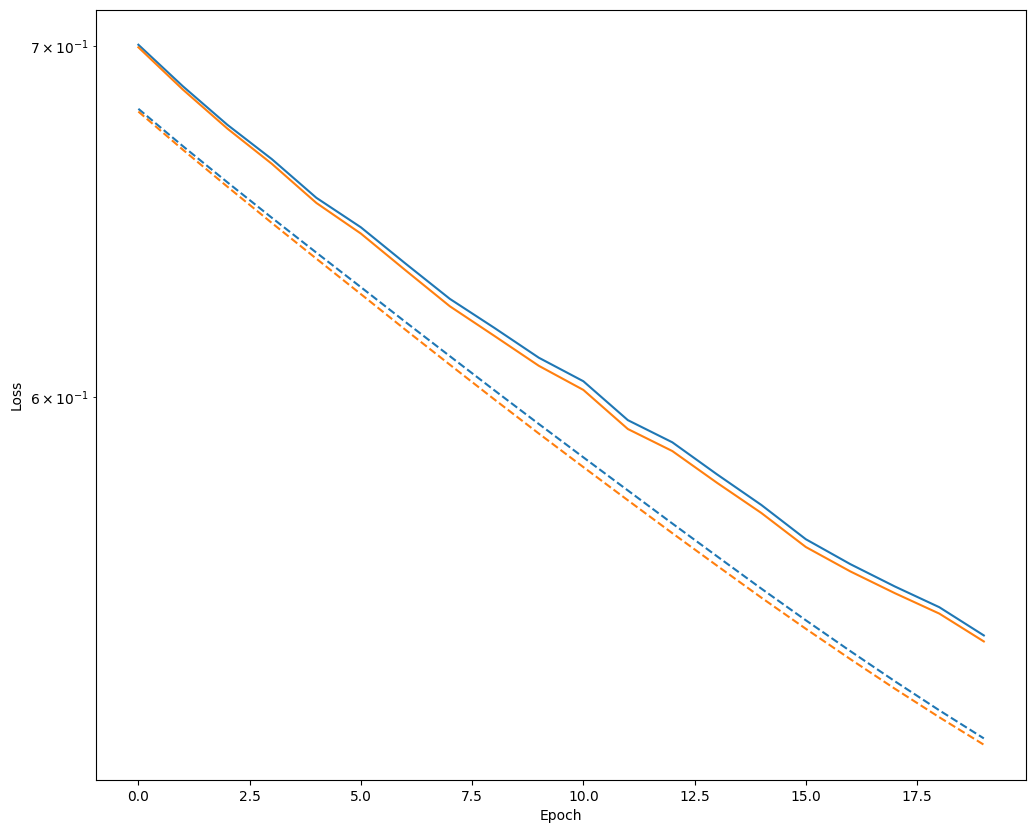

In [36]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [37]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

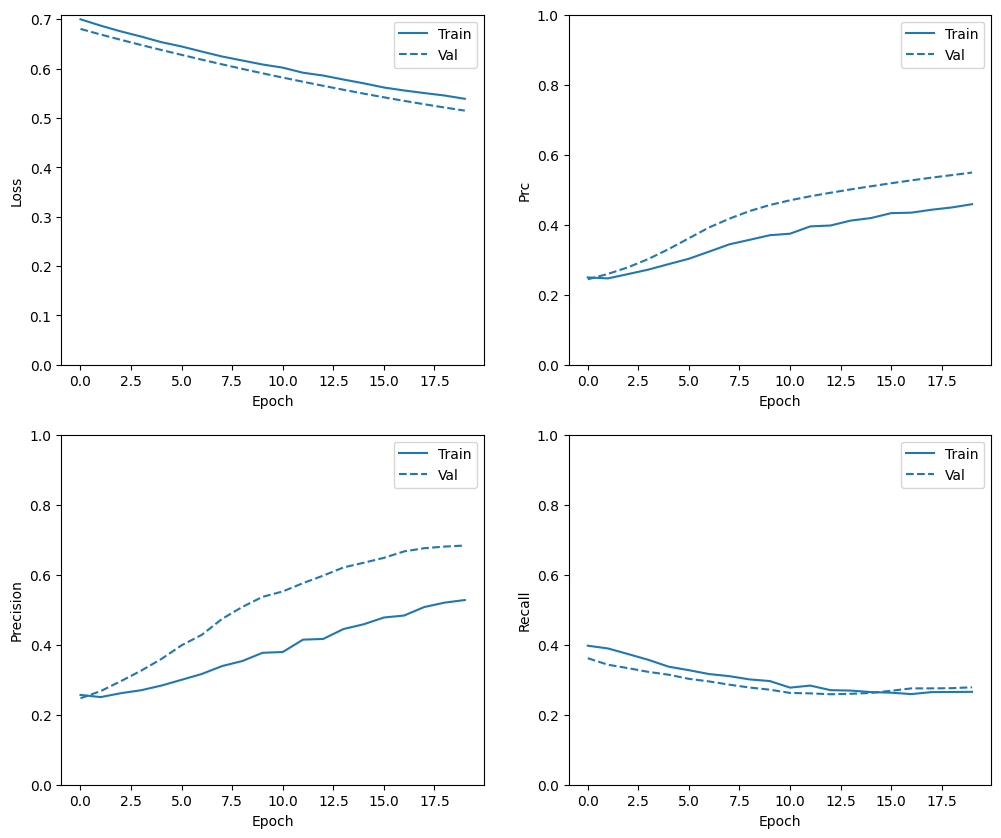

In [38]:
plot_metrics(careful_bias_history)


In [39]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

1/1 [==============================] - 0s 14ms/step


In [40]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels,predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


loss :  0.5147298574447632
tp :  449.0
fp :  208.0
tn :  4631.0
fn :  1164.0
accuracy :  0.7873527407646179
precision :  0.6834094524383545
recall :  0.27836328744888306
auc :  0.7567315697669983
prc :  0.549059271812439



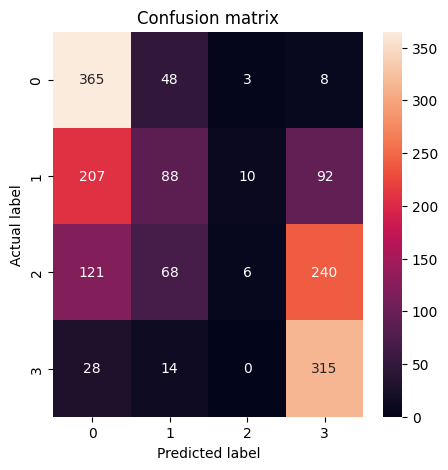

In [41]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(np.argmax(y_test.to_numpy(),axis=1), test_predictions_baseline.argmax(axis=1))

Generación de un modelo simple con un perceptron de una capa y pocas neuronas para conocer un poco donde estamos.

In [42]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
   
    #keras.layers.Dense(10, activation='relu'),

    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)
model.summary()
h_nocapas = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 17)                0         
                                                                 
 dense_12 (Dense)            (None, 4)                 72        
                                                                 
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
404/404 [==============================] - 1s 1ms/step - loss: 1.3406 - categorical_accuracy: 0.3116 - val_loss: 1.1671 - val_categorical_accuracy: 0.4582
Epoch 2/20
404/404 [==============================] - 0s 804us/step - loss: 1.0905 - categorical_accuracy: 0.4921 - val_loss: 1.0532 - val_categorical_accuracy: 0.5108
Epoch 3/20
404/404 [==============================] - 0s 829us/step - loss: 1.0046 - categorical_accuracy: 0.5328 - val_

Utilizando 1 capa y pocas neuronas

In [44]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(10, activation='elu'),

    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_unacapa =model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 17)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                180       
                                                                 
 dense_14 (Dense)            (None, 4)                 44        
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
404/404 [==============================] - 1s 1ms/step - loss: 1.0529 - categorical_accuracy: 0.5186 - val_loss: 0.9085 - val_categorical_accuracy: 0.5784
Epoch 2/20
404/404 [==============================] - 0s 911us/step - loss: 0.8215 - categorical_accuracy: 0.6277 - val_loss: 0.7788 - val_categorical_acc

Utilizando dos capas

In [45]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(10, activation='elu'),
    keras.layers.Dense(10, activation='elu'),


    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_doscapas =model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 17)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                180       
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 4)                 44        
                                                                 
Total params: 334
Trainable params: 334
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
404/404 [==============================] - 1s 1ms/step - loss: 0.9522 - categorical_accuracy: 0.5551 - val_loss: 0.7858 - val_categorical_accuracy: 0.6448
Epoch 2/20
404/404 [==

Observamos que a mas capas, mejores resultados. Verificación utilizando muchas neuronas por capa

In [19]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dense(128, activation='elu'),


    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_128128= model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 17)                0         
                                                                 
 dense_21 (Dense)            (None, 128)               2304      
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 4)                 516       
                                                                 
Total params: 19,332
Trainable params: 19,332
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
404/404 [==============================] - 1s 1ms/step - loss: 0.7276 - categorical_accuracy: 0.6681 - val_loss: 0.5722 - val_categorical_accuracy: 0.7396
Epoch 2/20
404/

Resultados mejores. Probamos con aún más neuronas.

In [27]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dense(512, activation='elu'),


    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_512512= model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 17)                0         
                                                                 
 dense_24 (Dense)            (None, 512)               9216      
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dense_26 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 273,924
Trainable params: 273,924
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
404/404 [==============================] - 2s 4ms/step - loss: 0.7117 - categorical_accuracy: 0.6733 - val_loss: 0.5632 - val_categorical_accuracy: 0.7483
Epoch 2/20
40

Añadir más neuronas auemnta el tiempo de entrenamiento ligeramente (CPU only) sin dar mejores resultados

In [36]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dense(512, activation='elu'),




    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_512x4= model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 17)                0         
                                                                 
 dense_32 (Dense)            (None, 512)               9216      
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 dense_36 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 799,236
Trainable params: 799,236
Non-t

El objetivo ahora es conseguir un modelo lo bastante grande que haga overfit a los datos y reducirlo

In [48]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),




    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_100x4x20= model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test)) #menos epoch

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 17)                0         
                                                                 
 dense_28 (Dense)            (None, 100)               1800      
                                                                 
 dense_29 (Dense)            (None, 100)               10100     
                                                                 
 dense_30 (Dense)            (None, 100)               10100     
                                                                 
 dense_31 (Dense)            (None, 100)               10100     
                                                                 
 dense_32 (Dense)            (None, 4)                 404       
                                                                 
Total params: 32,504
Trainable params: 32,504
Non-tra

Como la precisión no parece estancarse lo dejamos durante muchas mas epocas

In [47]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),




    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_100x4x100= model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 17)                0         
                                                                 
 dense_23 (Dense)            (None, 128)               2304      
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dense_27 (Dense)            (None, 4)                 516       
                                                                 
Total params: 52,356
Trainable params: 52,356
Non-tra

Observamos el overfit del modelo

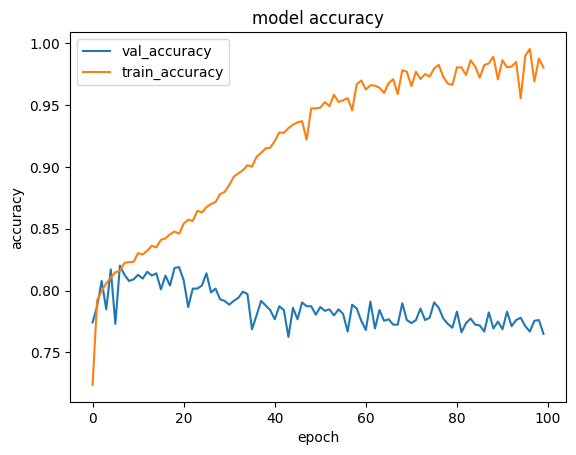

In [40]:
plt.plot(h_100x4x100.history['val_categorical_accuracy'])
plt.plot(h_100x4x100.history['categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy','train_accuracy'], loc='upper left')
plt.show()
# "Loss"

Aplicamos estrategias de regularización.

In [46]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),





    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_100x4x100= model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 17)                0         
                                                                 
 dense_18 (Dense)            (None, 100)               1800      
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 100)               10100     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_20 (Dense)            (None, 100)               10100     
                                                                 
 dropout_8 (Dropout)         (None, 100)              

Tiene buana pinta

In [43]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),





    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_100x4x100= model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test))

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 17)                0         
                                                                 
 dense_62 (Dense)            (None, 100)               1800      
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_63 (Dense)            (None, 100)               10100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_64 (Dense)            (None, 100)               10100     
                                                                 
 dropout_10 (Dropout)        (None, 100)             

Añadir una capa mas no aporta nada

In [45]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.25),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.25),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.25),
    





    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_100x4x100= model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test))

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 17)                0         
                                                                 
 dense_73 (Dense)            (None, 100)               1800      
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 dense_74 (Dense)            (None, 100)               10100     
                                                                 
 dropout_18 (Dropout)        (None, 100)               0         
                                                                 
 dense_75 (Dense)            (None, 100)               10100     
                                                                 
 dropout_19 (Dropout)        (None, 100)             

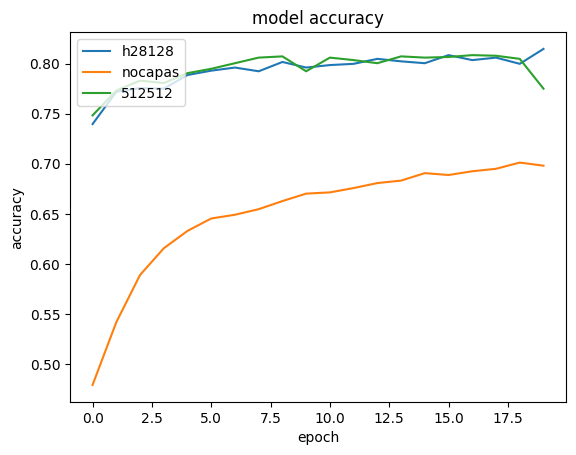

In [29]:
plt.plot(h_128128.history['val_categorical_accuracy'])
plt.plot(h_nocapas.history['val_categorical_accuracy'])
plt.plot(h_512512.history['val_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['h28128', 'nocapas','512512'], loc='upper left')
plt.show()
# "Loss"


IGNORAR NLP CON TORCH

In [5]:
import numpy as np

In [52]:
att.columns[2]

'ShortPassing'

In [55]:
cadenas = []
cadenas_target = []
for x,y in zip(att.to_numpy(),target.to_numpy()):
    temp = ['A football player with']
    for i in range(0,len(x)):
        temp.append(f' {att.columns[i]} of '+str(x[i])+',')
    cadenas.append((''.join(temp)[:-1]))
    cadenas_target.append(np.argmax(y,axis=0))

In [56]:
cadenas

['A football player with Crossing of -0.2195121951219512, HeadingAccuracy of 0.3164556962025315, ShortPassing of -0.041095890410959, Volleys of -0.125, Dribbling of -0.2771084337349396, Curve of -0.3734939759036143, FKAccuracy of -0.2857142857142858, LongPassing of -0.1621621621621622, BallControl of -0.2957746478873237, Reactions of -0.1466666666666667, ShotPower of 0.2592592592592593, Stamina of -0.36231884057971, LongShots of -0.1325301204819275, Aggression of 0.6585365853658536, Positioning of -0.5, Vision of -0.146341463414634, Composure of -0.0810810810810811',
 'A football player with Crossing of 0.6585365853658538, HeadingAccuracy of -0.3164556962025318, ShortPassing of 0.4794520547945207, Volleys of 0.175, Dribbling of 0.3975903614457832, Curve of 0.6626506024096386, FKAccuracy of 0.5952380952380951, LongPassing of 0.5405405405405408, BallControl of 0.295774647887324, Reactions of -0.04, ShotPower of 0.654320987654321, Stamina of -0.2173913043478259, LongShots of 0.59036144578

In [26]:
datos = []
for x,y in zip(cadenas,cadenas_target):


    misdatos  = {}
    misdatos['label'] = y
    misdatos['text'] = x
    datos.append(misdatos)


In [57]:
df = pd.DataFrame(data=np.reshape(cadenas,(-1,1)),columns=['text'])

In [58]:
df['label'] = np.reshape(cadenas_target,(-1,1))

In [59]:
from datasets import Dataset
ds = Dataset.from_pandas(df)
ds = ds.with_format('torch')
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

loading configuration file config.json from cache at C:\Users\xhiib/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\xhiib/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\vocab.txt
loading file tokenizer.json from cache at C:\Users\xhiib/.cache\huggingface\hub\models--dis

{'text': 'x0=-0.2195121951219512,x1=0.3164556962025315,x2=-0.041095890410959,x3=-0.125,x4=-0.2771084337349396,x5=-0.3734939759036143,x6=-0.2857142857142858,x7=-0.1621621621621622,x8=-0.2957746478873237,x9=-0.1466666666666667,x10=0.2592592592592593,x11=-0.36231884057971,x12=-0.1325301204819275,x13=0.6585365853658536,x14=-0.5,x15=-0.146341463414634,x16=-0.0810810810810811',
 'label': tensor(1)}

In [10]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

In [60]:
ds = ds.map(preprocess_function, batched=True)


100%|██████████| 17/17 [00:02<00:00,  7.65ba/s]


In [12]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16122
})

In [61]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

loading configuration file config.json from cache at C:\Users\xhiib/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\xhiib

In [40]:
from datasets import load_metric
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [64]:
ds = ds.train_test_split(0.3)

In [65]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
c:\Users\xhiib\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11285
  Num Epochs = 5
  Instantaneous batch siz

{'loss': 0.8852, 'learning_rate': 1.7167138810198304e-05, 'epoch': 0.71}


Model weights saved in ./results\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-500\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-500\special_tokens_map.json
 20%|█▉        | 705/3530 [01:50<07:00,  6.72it/s]The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4837
  Batch size = 16










































































































                                           
                                                   
 20%|██        | 707/3530 [02:05<2:47:44,  3.57s/it]

{'eval_loss': 0.5482497215270996, 'eval_accuracy': 0.7568740955137482, 'eval_runtime': 14.8701, 'eval_samples_per_second': 325.284, 'eval_steps_per_second': 20.376, 'epoch': 1.0}


 28%|██▊       | 1000/3530 [02:51<07:01,  6.00it/s]Saving model checkpoint to ./results\checkpoint-1000
Configuration saved in ./results\checkpoint-1000\config.json


{'loss': 0.5845, 'learning_rate': 1.4334277620396602e-05, 'epoch': 1.42}


Model weights saved in ./results\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-1000\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-1000\special_tokens_map.json
 40%|███▉      | 1411/3530 [03:56<05:19,  6.64it/s]The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4837
  Batch size = 16

























































































































                                           
                                                   
 40%|████      | 1413/3530 [04:12<2:15:10,  3.83s/it]

{'eval_loss': 0.6146692037582397, 'eval_accuracy': 0.7264833574529667, 'eval_runtime': 16.016, 'eval_samples_per_second': 302.01, 'eval_steps_per_second': 18.919, 'epoch': 2.0}


 42%|████▏     | 1500/3530 [04:26<05:06,  6.63it/s]Saving model checkpoint to ./results\checkpoint-1500
Configuration saved in ./results\checkpoint-1500\config.json


{'loss': 0.5402, 'learning_rate': 1.1501416430594903e-05, 'epoch': 2.12}


Model weights saved in ./results\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-1500\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-1500\special_tokens_map.json
 57%|█████▋    | 2000/3530 [05:43<03:51,  6.60it/s]Saving model checkpoint to ./results\checkpoint-2000
Configuration saved in ./results\checkpoint-2000\config.json


{'loss': 0.4932, 'learning_rate': 8.668555240793202e-06, 'epoch': 2.83}


Model weights saved in ./results\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-2000\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-2000\special_tokens_map.json
 60%|█████▉    | 2117/3530 [06:02<04:17,  5.48it/s]The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4837
  Batch size = 16















































































































































                                           
                                                   
 60%|██████    | 2119/3530 [06:20<1:40:04,  4.26s/it]

{'eval_loss': 0.5020758509635925, 'eval_accuracy': 0.7777548066983667, 'eval_runtime': 17.7695, 'eval_samples_per_second': 272.208, 'eval_steps_per_second': 17.052, 'epoch': 3.0}


 71%|███████   | 2500/3530 [07:29<03:14,  5.30it/s]Saving model checkpoint to ./results\checkpoint-2500
Configuration saved in ./results\checkpoint-2500\config.json


{'loss': 0.4645, 'learning_rate': 5.835694050991501e-06, 'epoch': 3.54}


Model weights saved in ./results\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-2500\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-2500\special_tokens_map.json
 80%|███████▉  | 2823/3530 [08:30<02:21,  5.01it/s]The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4837
  Batch size = 16

























































































































































                                           
                                                   
 80%|████████  | 2825/3530 [08:49<52:20,  4.45s/it]

{'eval_loss': 0.4739629030227661, 'eval_accuracy': 0.7916063675832128, 'eval_runtime': 18.55, 'eval_samples_per_second': 260.755, 'eval_steps_per_second': 16.334, 'epoch': 4.0}


 85%|████████▍ | 3000/3530 [09:22<01:51,  4.76it/s]Saving model checkpoint to ./results\checkpoint-3000
Configuration saved in ./results\checkpoint-3000\config.json


{'loss': 0.4438, 'learning_rate': 3.0028328611898022e-06, 'epoch': 4.25}


Model weights saved in ./results\checkpoint-3000\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-3000\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-3000\special_tokens_map.json
 99%|█████████▉| 3500/3530 [10:52<00:05,  5.52it/s]Saving model checkpoint to ./results\checkpoint-3500
Configuration saved in ./results\checkpoint-3500\config.json


{'loss': 0.428, 'learning_rate': 1.69971671388102e-07, 'epoch': 4.96}


Model weights saved in ./results\checkpoint-3500\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-3500\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-3500\special_tokens_map.json
100%|█████████▉| 3529/3530 [10:58<00:00,  5.25it/s]The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4837
  Batch size = 16
























































































































































                                           
                                                   
100%|██████████| 3530/3530 [11:19<00:00,  5.25it/s]


Training completed. Do not forget to share your model on huggingface.co/models =)

{'eval_loss': 0.4838247299194336, 'eval_accuracy': 0.7911928881538144, 'eval_runtime': 20.5515, 'eval_samples_per_second': 235.36, 'eval_steps_per_second': 14.743, 'epoch': 5.0}
{'train_runtime': 679.2746, 'train_samples_per_second': 83.067, 'train_steps_per_second': 5.197, 'train_loss': 0.5476314025965359, 'epoch': 5.0}


TrainOutput(global_step=3530, training_loss=0.5476314025965359, metrics={'train_runtime': 679.2746, 'train_samples_per_second': 83.067, 'train_steps_per_second': 5.197, 'train_loss': 0.5476314025965359, 'epoch': 5.0})